In [11]:
import csv
import os
import numpy as np
import pandas as pd
import pickle as pk

from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
from matplotlib import pyplot as plt

from run_error import run_all_groups

## Analyze topics

In [12]:
f = open('data/mallet_topics_2500.txt', 'r')
results = csv.reader(f, delimiter='\t')
results_lst = list(results)

In [13]:
topics_df = pd.DataFrame(results_lst, columns=['index', 'fname'] + list(range(50)))
for i in range(50):
    topics_df[i] = topics_df[i].apply(float)

topics_df['icustay_id'] = topics_df['fname'].apply(lambda x: x.split('.')[-2].split('/')[-1]).apply(float)

In [14]:
# Check that topic distribution values sum to 1.
topics_df[range(50)].head().values.sum(axis=1)

array([1., 1., 1., 1., 1.])

In [15]:
patient_info = pd.read_csv('data/patients_info.csv')

In [16]:
patient_info['insurance'].value_counts()

Medicare      14540
Private        8186
Medicaid       2275
Government      650
Self Pay        229
Name: insurance, dtype: int64

In [17]:
print(len(topics_df))
print(len(patient_info))
df = topics_df.merge(patient_info, on='icustay_id', how='inner')

print(len(df))

25880
25880
25880


In [18]:
def insur_pubpriv(x):
    if x == 'Medicare' or x == 'Medicaid' or x == 'Government':
        return 'public'
    elif x == 'Private':
        return 'private'
    elif x == 'Self Pay':
        return 'other'
    
df['insur_group'] = df['insurance'].apply(insur_pubpriv)

dummies = pd.get_dummies(df[['insur_group']])
df[dummies.columns] = dummies

In [19]:
df['male'] = df['gender']
df['female'] = 1 - df['gender']

In [20]:
print('Race & ' + ' & '.join(['Asian', str(df['eth_asian'].sum()), ('%.1f' % (100 * df[df['eth_asian'] == 1]['mort_hosp'].mean()))]) + ' //')
print(' & ' + ' & '.join(['Black', str(df['eth_black'].sum()), ('%.1f' % (100 * df[df['eth_black'] == 1]['mort_hosp'].mean()))]) + ' //')
print(' & ' + ' & '.join(['Hispanic', str(df['eth_hispanic'].sum()), ('%.1f' % (100 * df[df['eth_hispanic'] == 1]['mort_hosp'].mean()))]) + ' //')
print(' & ' + ' & '.join(['White', str(df['eth_white'].sum()), ('%.1f' % (100 * df[df['eth_white'] == 1]['mort_hosp'].mean()))]) + ' //')
print(' & ' + ' & '.join(['Other', str(df['eth_other'].sum()), ('%.1f' % (100 * df[df['eth_other'] == 1]['mort_hosp'].mean()))]) + ' //')
print('\hline')
print('Gender & ' + ' & '.join(['Female', str(df['female'].sum()), ('%.1f' % (100 * df[df['female'] == 1]['mort_hosp'].mean()))]) + ' //')
print(' & ' + ' & '.join(['Male', str(df['male'].sum()), ('%.1f' % (100 * df[df['male'] == 1]['mort_hosp'].mean()))]) + ' //')
print('\hline')
print('Insurance & ' + ' & '.join(['Private', str(df['insur_group_private'].sum()), ('%.1f' % (100 * df[df['insur_group_private'] == 1]['mort_hosp'].mean()))]) + ' //')
print(' & ' + ' & '.join(['public', str(df['insur_group_public'].sum()), ('%.1f' % (100 * df[df['insur_group_public'] == 1]['mort_hosp'].mean()))]) + ' //')
print(' & ' + ' & '.join(['public', str(df['insur_group_other'].sum()), ('%.1f' % (100 * df[df['insur_group_other'] == 1]['mort_hosp'].mean()))]) + ' //')
print()

Race & Asian & 583 & 14.2 //
 & Black & 2327 & 10.9 //
 & Hispanic & 832 & 10.3 //
 & White & 18377 & 13.4 //
 & Other & 3761 & 18.4 //
\hline
Gender & Female & 11077 & 13.8 //
 & Male & 14803 & 13.8 //
\hline
Insurance & Private & 8186 & 11.2 //
 & public & 17465 & 15.0 //
 & public & 229 & 16.6 //



In [21]:
q_nk = df[range(50)]

feat_cols = ['female', 'male',           u'eth_asian',           u'eth_black',
              u'eth_hispanic',           u'eth_white', 'eth_other', 
       u'insur_group_private',  u'insur_group_public', u'insur_group_other']



In [22]:
f = open('data/mallet_topics_50_2500.txt', 'r')
results = csv.reader(f, delimiter='\t')
results_lst = list(results)
topics = pd.DataFrame(results_lst)
f.close()

In [23]:
top_words = {int(i): i+' &  '+' '.join(j.split(' ')[:5])  for i,j in zip(topics[0].values, topics[2].values)}

In [24]:
feat_cols = ['female', 'male',           u'eth_asian',           u'eth_black',
              u'eth_hispanic',           u'eth_white', 'eth_other', 
       u'insur_group_private',  u'insur_group_public', u'insur_group_other']

In [25]:
for i,feat in enumerate(feat_cols):
    feat_enrich = df[feat].values.dot(q_nk.values) / q_nk.values.sum(axis=0)
    top_topic_ind = np.argsort(feat_enrich)[::-1]
    for jx, j in enumerate(top_topic_ind[:5]):
        prefix = feat.title().replace('_', '') + ' & ' if jx == 0 else ' & '
        print(prefix, top_words[j], ' \\\\ ')
    print('\\hline')

Female &  10 &  copd home bipap chronic respiratory  \\ 
 &  45 &  artery carotid aneurysm left numeric  \\ 
 &  8 &  pain morphine control dilaudid plan  \\ 
 &  28 &  lasix sats respiratory mask cxr  \\ 
 &  48 &  mass cancer metastatic lung patient  \\ 
\hline
Male &  44 &  etoh abuse ciwa withdrawal alcohol  \\ 
 &  47 &  pacer pacemaker icd s/p paced  \\ 
 &  20 &  fracture left trauma s/p fractures  \\ 
 &  0 &  chest reason tube clip left  \\ 
 &  40 &  liver cirrhosis hepatic ascites portal  \\ 
\hline
EthAsian &  48 &  mass cancer metastatic lung patient  \\ 
 &  29 &  procedure catheter identifier numeric clip  \\ 
 &  13 &  arrest pericardial cardiac effusion s/p  \\ 
 &  26 &  pancreatitis ercp hospital biliary pancreatic  \\ 
 &  46 &  neuro head left hemorrhage sbp  \\ 
\hline
EthBlack &  6 &  renal dialysis esrd line transplant  \\ 
 &  32 &  renal failure insulin acute plan  \\ 
 &  10 &  copd home bipap chronic respiratory  \\ 
 &  21 &  mental status altered seizure h

## MIMIC performance

In [26]:
# load topics and make graph

# calculate accuracy for data

In [27]:
if os.path.exists('results/race_LR_all.pk'):
    f = open('results/race_LR_all.pk', 'rb')
    races = pk.load(f)
    f.close()

    f = open('results/insurance_LR_all.pk', 'rb')
    insurance = pk.load(f)
    f.close()

    f = open('results/gender_LR_all.pk', 'rb')
    gender = pk.load(f)
    f.close()
else:
    # output creates pickle files in results/
    run_all_groups(trials=5)

In [28]:
print(races['zo_results'].groupby('race').mean())

print(gender['zo_results'].groupby('race').mean())

print(insurance['zo_results'].groupby('race').mean())

                zo
race              
Asian     0.200670
Black     0.174361
Hispanic  0.153902
Other     0.213447
White     0.188198
              zo
race            
Female  0.190436
Male    0.185183
               zo
race             
Private  0.161898
Public   0.199456


In [29]:
def plot_sim2(tukey, fname='notes', xlabel='Zero-One Loss', xticks=None):
    tukey._simultaneous_ci()
    means = tukey._multicomp.groupstats.groupmean
    minrange = [means[i] - tukey.halfwidths[i] for i in range(len(means))]
    maxrange = [means[i] + tukey.halfwidths[i] for i in range(len(means))]

    colors = ['#d62728','#1f77b4', '#ff7f0e', '#2ca02c', 
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
#     colors = ['r', 'b', 'g', 'k', 'm']
    mks = ['o', '^', 'P', 's', '*']


    # x, height, error = range(5), [2] * 4, range(1,5)
    # colors = ['red', 'green', 'blue', 'cyan', 'magenta']

    fig, ax = plt.subplots()
    # ax.bar(x, height, alpha=0.5, color=colors)
    ax.margins(0.05)
    x_vals = range(len(means))

    protected = tukey.groupsunique

    errN = dict()
    meansN = dict()
    mksN = dict()
    colorsN = dict()

    for pix, p in enumerate(protected):
        errN[p] = tukey.halfwidths[pix]
        meansN[p] = means[pix]
        colorsN[p] = color_cols[p.lower()]
        mksN[p] = 's'

    sort_prot = sorted(protected)
    # pdb.set_trace()
    for pix2, p in enumerate(sort_prot):
        # print x_vals[pix2], p
        ax.errorbar(meansN[p], len(protected) - 1 -x_vals[pix2], marker='s', markersize=20, xerr=errN[p], lw=2, capsize=10, capthick=5, color=colorsN[p], elinewidth=5)

    ax.xaxis.grid()

    # for mean, x, err, color, mark in zip(means, x_vals, tukey.halfwidths, colors, mks):
    #     # pdb.set_trace()
    #     ax.errorbar(mean, x, xerr=err, lw=2, capsize=10, capthick=5, color=color, elinewidth=5,marker=mark, markersize=20)

    r = np.max(maxrange) - np.min(minrange)
    ax.set_ylim([-1, tukey._multicomp.ngroups])
    ax.set_xlim([np.min(minrange) - r / 10., np.max(maxrange) + r / 10.])
    
    def clean_p(x):
        spltx = x.split('_')
        if len(spltx) == 1:
            return x
        else:
            return spltx[1]
        
    sort_prot2 = sorted([clean_p(i) for i in protected], reverse=True)
    ax.set_yticklabels(sort_prot2, fontsize=16)
    ax.set_yticks(np.arange(0, len(means)))
    plt.setp(ax.get_xticklabels(), fontsize=12)
    if xticks != None:
        plt.xticks(xticks)
    plt.tight_layout()
    plt.xlabel(xlabel, fontsize=16)
      
#     plt.savefig('plots/%s.pdf' % fname, bbox_inches='tight')

In [30]:
color_cols = {
 'eth_asian': '#2ca02c', 
'eth_black':'#ff7f0e',
 'eth_hispanic': '#9467bd',
 'eth_white':'#bcbd22', 
 'eth_other':'#7f7f7f',
    'asian':'#2ca02c', 
'black':'#ff7f0e',
 'hispanic': '#9467bd',
 'white':'#bcbd22', 
 'other':'#7f7f7f',
 'gender_female':'#d62728', 
 'gender_male':'#1f77b4',
 'female':'#d62728', 
 'male':'#1f77b4',
    'gender_woman':'#d62728', 
 'gender_man':'#1f77b4',
 'insurance_private':'#8c564b', 
    'insurance_public':'#17becf',
 'private':'#8c564b', 
    'public':'#17becf',
    'insur_group_public': '#17becf',
    'insur_group_private': '#8c564b'

}

Because of stochasticity, the results may be a little different. For plotting asthetics, change x-ticks as needed.

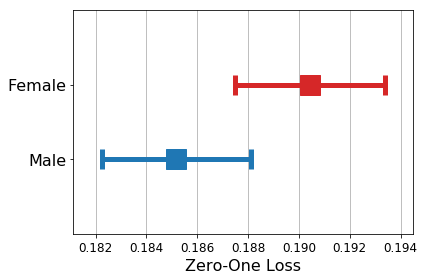

In [31]:
tukey = pairwise_tukeyhsd(groups=gender['zo_results']['race'], endog=gender['zo_results']['zo'].values)
plot_sim2(tukey, fname='mimic_gender', xticks=[0.182, 0.184, 0.186, 0.188, 0.190, 0.192, 0.194])
plt.tight_layout()
plt.savefig('plots/mimic_gender.pdf', format='pdf', dpi=1000)


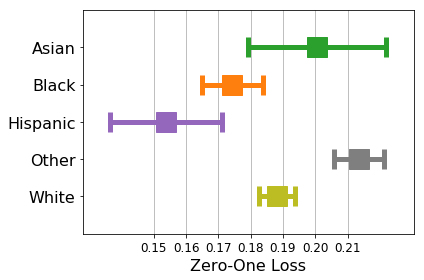

In [32]:
tukey = pairwise_tukeyhsd(groups=races['zo_results']['race'], endog=races['zo_results']['zo'].values)
plot_sim2(tukey, fname='mimic_race', xticks=[0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21])
plt.tight_layout()
plt.savefig('plots/mimic_race.pdf', format='pdf', dpi=1200)

In [33]:
tukey = pairwise_tukeyhsd(groups=gender['zo_results']['race'], endog=gender['zo_results']['zo'].values)


In [34]:
len(gender['zo_results']['zo'].values)

25880

In [35]:
len(gender['zo_results']['race'])

25880

In [36]:
len(insurance['zo_results']['race'])

25688

In [37]:
len(insurance['zo_results']['zo'].values)

25688

Note: for some reason, `pairwise_tukeyhsd` had a bug here, so I had to edit to source to `/data/ml2/software/anaconda3/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py`

I added `if type(res[8]

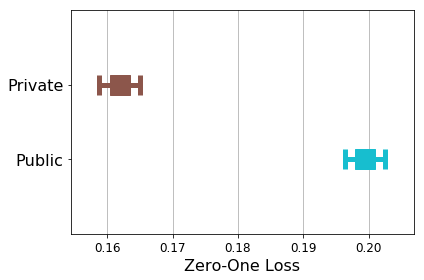

In [38]:
tukey = pairwise_tukeyhsd(groups=insurance['zo_results']['race'], endog=insurance['zo_results']['zo'].values)
plot_sim2(tukey, fname='mimic_insur')
plt.tight_layout()
plt.savefig('plots/mimic_insur.pdf', format='pdf', dpi=1200)

## Plot MIMIC Topics

In [39]:
# create data (q_nk) from df
data = dict()

for i,feat in enumerate(feat_cols):
    feat_enrich = df[feat].values.dot(q_nk.values) / q_nk.values.sum(axis=0)
    data[feat] = feat_enrich

In [40]:
valid_cols = [
 'eth_asian',
'eth_black',
 'eth_hispanic',
 'eth_white',
 'eth_other',
 'female', 
    'male',
 'insur_group_private',
    'insur_group_public',
]

race_cols = [
 'eth_asian',
'eth_black',
 'eth_hispanic',
 'eth_white',
 'eth_other'
]

gender_cols = [  'female','male',
]

insur_cols = [ 'insur_group_private',
    'insur_group_public'
]

In [41]:
# Base rates for dataset, hard-coded

N = len(df) * 1.

base_rates = {
 'eth_asian':583/N,
'eth_black':2327/N,
 'eth_hispanic':832/N,
 'eth_white': 18377/N,
 'eth_other': 3761/N,
 'female':11077/N, 
'male':14803/N,
 'insur_group_private':8186/N,
 'insur_group_public':(17465)/N,
}

In [42]:
race_enrich = dict()
gender_enrich = dict()
insur_enrich = dict()

# rand_topics = [random.randint(0,49) for i in xrange(5)]

# for t in topics:
for t in range(50):
    results = list()
    for col in race_cols:
        results.append(data[col][t] / data[col].sum())
    race_enrich[t] = results
    
    results = list()
    for col in gender_cols:
        results.append(data[col][t] / data[col].sum())
    gender_enrich[t] = results
    
    results = list()
    for col in insur_cols:
        results.append(data[col][t] / data[col].sum())
    insur_enrich[t] = results

In [43]:
topic_titles = {
    48:'Cancer',
    10: 'COPD',
    44: 'Substance abuse',
    13: 'Cardiac arrest',
    21: 'Cognitive issues',
    5: 'Heart failure',
    6: 'Renal failure'
}

Cancer 48
COPD 10
Substance abuse 44
Cardiac arrest 13
Cognitive issues 21
Heart failure 5
Renal failure 6


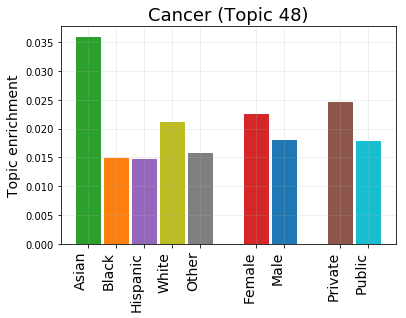

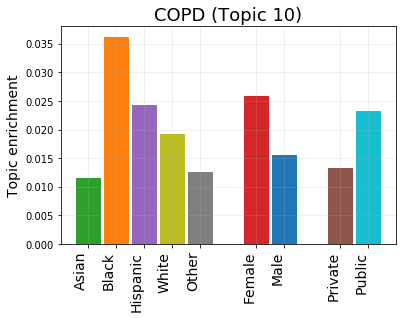

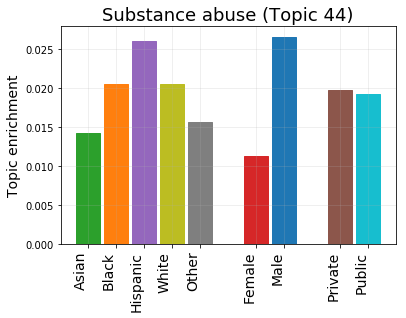

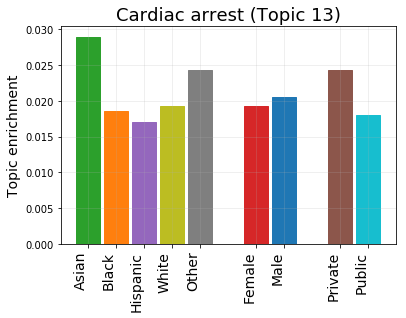

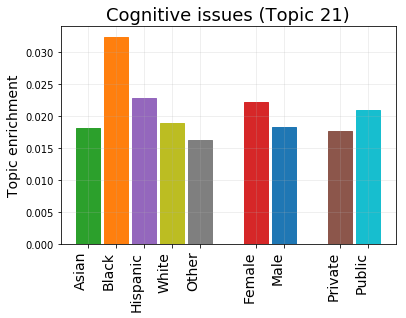

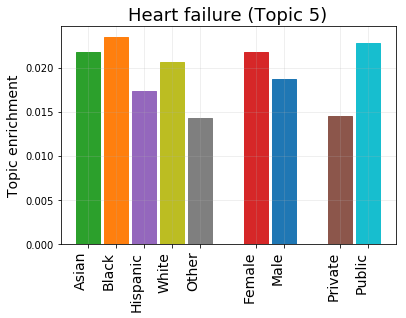

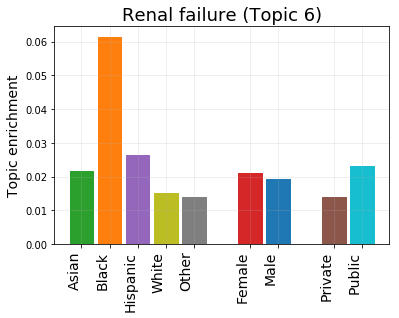

In [44]:
for topic_num in topic_titles:
    bar_width=0.85

    # pdb.set_trace()

    plt.figure()
    plt.grid(alpha=0.25)
    barlist0 = plt.bar(np.arange(5), race_enrich[topic_num], bar_width, )
    barlist1 = plt.bar(np.arange(6,8), gender_enrich[topic_num], bar_width)
    barlist2 = plt.bar(np.arange(9,11), insur_enrich[topic_num], bar_width)
    plt.ylabel('Topic enrichment', fontsize=14)

    colors = ['#d62728','#1f77b4', '#ff7f0e', '#2ca02c', 
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
#     colors = ['r', 'b', 'g','k','m']

    for i,c in enumerate(race_cols):
        barlist0[i].set_color(color_cols[c])
    
    for i,c in enumerate(gender_cols):
        barlist1[i].set_color(color_cols[c])
        
    for i,c in enumerate(insur_cols):
        barlist2[i].set_color(color_cols[c])

    race_labels = ['Asian', 'Black', 'Hispanic', 'White', 'Other']
    gender_labels = ['Female', 'Male']
    insur_labels = ['Private', 'Public']
    plt.xticks([0,1,2,3,4, 6,7, 9,10], race_labels + gender_labels+insur_labels, fontsize=14, ha='right', rotation=90)
    def autolabel(rects, topic_n):
        """
        Attach a text label above each bar displaying its height
        """
        for ri, rect in enumerate(rects):
            height = rect.get_height()
            plt.text(rect.get_x() -0.08, height + 0.0055,
                    '%d' % int(prev[:,topic_n][ri]),
                    ha='left', va='bottom', fontsize=17)

    print(topic_titles[topic_num], topic_num)
    plt.title('%s (Topic %d)' % (topic_titles[topic_num], topic_num), fontsize=18)
    plt.savefig('plots/mimic_topics_%s.pdf' % topic_num, bbox_inches='tight')